In [116]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

# min-max scaler
from sklearn.preprocessing import MinMaxScaler

# recursive feature elimination
from sklearn.feature_selection import RFE

# estimators
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor

In [117]:
# read clean electricity data to create target variable array y
elec = pd.read_csv('../data/elec_clean.csv',index_col=0)
elec.index = pd.to_datetime(elec.index,format='%Y-%m-%d %H:00:00')

# remove Davenport for now because it is missing most of June and July
elec.drop('Davenport',axis=1,inplace=True)

agg = pd.DataFrame({'actual':elec.sum(axis=1)})

### Add features

In [86]:
# add lag features
for i in [1,2,3,24,25,26,48,49,50]:
    agg['t-'+str(i)] = np.append(np.array([np.nan]*i),agg['actual'][0:len(agg)-i])
    
# add day of week features
days = ['mon','tues','wed','thurs','fri','sat','sun']
for i in range(7):
    agg[days[i]] = (np.array([i]*len(agg))==np.asarray(agg.index.dayofweek)).astype(int)
    
# add hour of day features
for i in range(12):
    agg[str(i)+'am'] = (np.array([i]*len(agg))==np.asarray(agg.index.hour)).astype(int)
for i in range(12,24):
    agg[str(i-12)+'pm'] = (np.array([i]*len(agg))==np.asarray(agg.index.hour)).astype(int)
agg.rename({'0am':'12am','0pm':'12pm'},axis=1)

# feature for school breaks
agg['break'] = (agg.index.isin(pd.date_range(start='01/01/2018', end='01/15/2018', freq='H',closed='left'))
                | agg.index.isin(pd.date_range(start='03/10/2018', end='03/25/2018', freq='H',closed='left'))
                | agg.index.isin(pd.date_range(start='05/10/2018', end='08/22/2018', freq='H',closed='left'))
               ).astype(int)

# feature for office holidays: MLK day, memorial day, 4th of july
agg['holiday'] = (agg.index.isin(pd.date_range(start='01/15/2018', end='01/16/2018', freq='H',closed='left'))
                  | agg.index.isin(pd.date_range(start='05/28/2018', end='05/29/2018', freq='H',closed='left'))
                  | agg.index.isin(pd.date_range(start='07/04/2018', end='07/05/2018', freq='H',closed='left'))
                 ).astype(int)

# trim NaNs from lag calculation
data = agg['2018-01-04 00:00:00':]

### Evaluate feature importance

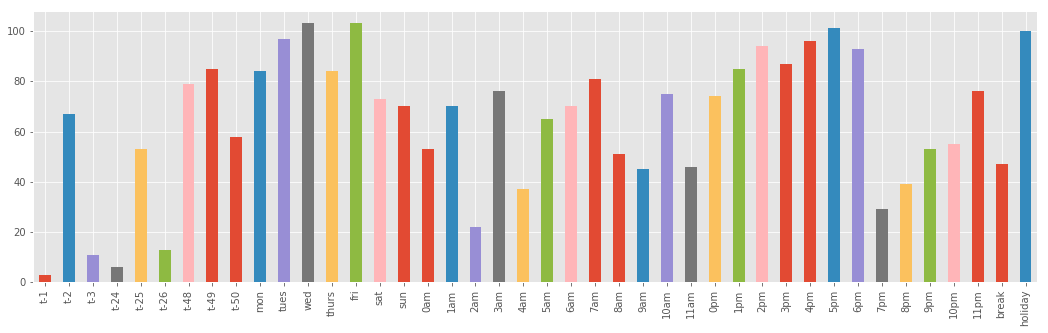

In [92]:
X = data.loc[:,'t-1':].values
y = data.loc[:,'actual'].values.reshape(-1, 1)

X_scaler = MinMaxScaler().fit(X)
y_scaler = MinMaxScaler().fit(y)

X_rfe = X_scaler.transform(X)
y_rfe = y_scaler.transform(y).ravel()

model_names = ['Linear Regression','Support Vector Regression','Decision Tree Regression']
models = [LinearRegression(),SVR(kernel='linear'),DecisionTreeRegressor()]
results = pd.DataFrame(index=data.loc[:,'t-1':].columns)

for i in range(len(models)):
    rfe = RFE(models[i], 1)
    rfe = rfe.fit(X_rfe, y_rfe)
    results[model_names[i]] = rfe.ranking_
    
results['Cumulative Score'] = results.sum(axis=1)
results['Cumulative Score'].plot(kind='bar',figsize=(18,5))

### Writing iterative forecasting procedure

In [107]:
# create static features dataframe
static_features = pd.DataFrame(index=pd.date_range(start='2018-01-01', end='2019-01-01', freq='H',closed='left'))

# add day of week features
days = ['mon','tues','wed','thurs','fri','sat','sun']
for i in range(7):
    static_features[days[i]] = (np.array([i]*len(static_features))==np.asarray(static_features.index.dayofweek)).astype(int)
    
# add hour of day features
for i in range(12):
    static_features[str(i)+'am'] = (np.array([i]*len(static_features))==np.asarray(static_features.index.hour)).astype(int)
for i in range(12,24):
    static_features[str(i-12)+'pm'] = (np.array([i]*len(static_features))==np.asarray(static_features.index.hour)).astype(int)
static_features = static_features.rename({'0am':'12am','0pm':'12pm'},axis=1)

# feature for school breaks
static_features['break'] = (static_features.index.isin(pd.date_range(start='01/01/2018', end='01/15/2018', freq='H',closed='left'))
                            | static_features.index.isin(pd.date_range(start='03/10/2018', end='03/25/2018', freq='H',closed='left'))
                            | static_features.index.isin(pd.date_range(start='05/10/2018', end='08/22/2018', freq='H',closed='left'))
                           ).astype(int)

# feature for office holidays: MLK day, memorial day, 4th of july
static_features['holiday'] = (static_features.index.isin(pd.date_range(start='01/15/2018', end='01/16/2018', freq='H',closed='left'))
                              | static_features.index.isin(pd.date_range(start='05/28/2018', end='05/29/2018', freq='H',closed='left'))
                              | static_features.index.isin(pd.date_range(start='07/04/2018', end='07/05/2018', freq='H',closed='left'))
                             ).astype(int)

static_features.head(3)



,mon,tues,wed,thurs,fri,sat,sun,12am,1am,2am,...,4pm,5pm,6pm,7pm,8pm,9pm,10pm,11pm,break,holiday
2018-01-01 00:00:00,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
2018-01-01 01:00:00,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
2018-01-01 02:00:00,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0


In [112]:
# create lag features dataframe on which to build test rows
lag_features = pd.DataFrame({'actual':elec.sum(axis=1)})
for i in [1,2,3,24,25,26,48,49,50]:
    lag_features['t-'+str(i)] = np.append(np.array([np.nan]*i),lag_features['actual'][0:len(lag_features)-i])
lag_features = lag_features['2018-01-04 00:00:00':]

X = lag_features.loc[:,'t-1':]
y = lag_features.loc[:,'actual']
 
X_train = X_scaler.transform(X[:'2018-05-31 23:00:00'].values)
y_train = y_scaler.transform(y[:'2018-05-31 23:00:00'].values.reshape(-1, 1))

for i in [1]:
    # initialize the X_test, in the future this will be constructed using y_pred...
    X_test = X[3793]
    
    
    reg = LinearRegression().fit(X_train_active, y_train_active)
    y_pred = reg.predict(X_test.reshape(1, -1))
    

ValueError: operands could not be broadcast together with shapes (3552,9) (42,) (3552,9) 

array([[680. , 674. , 710.2, ..., 704. , 695.8, 691.8],
       [676.7, 680. , 674. , ..., 691.6, 704. , 695.8],
       [662. , 676.7, 680. , ..., 643.9, 691.6, 704. ],
       ...,
       [886.9, 916.3, 978.4, ..., 694.7, 701.2, 811.7],
       [835.9, 886.9, 916.3, ..., 688.7, 694.7, 701.2],
       [765.9, 835.9, 886.9, ..., 673.3, 688.7, 694.7]])